## Setup & Data

In [20]:
# Import pytorch
import torch
from torch import nn

# Import torch vision
import torchvision
from torchvision import transforms, datasets

# Import matplotlib for visualisation
import matplotlib.pyplot as plt

In [21]:
# Define augmentation and normalisation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Normalise and transform test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Setup training data
train_data = datasets.CIFAR10(
    root="sample_data",
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="sample_data",
    train=False,
    download=True,
    transform=test_transform
)

In [22]:
# Dislpay the first image and its corresponding lable from the training dataset
img, label = train_data[0]
img, label

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000,  0.7255,  0.5765,  ..., -0.1137, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0588, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.3412, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000,  0.4275,  0.1765,  ..., -0.2235, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.2000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0275, -1.0000, -1.0000]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000,

# About the data

- Input and output shapes
- Lables
- Sample images

In [23]:
# Per-sample input shape
print(f"Per-sample input shape: {img.shape}") # [3, 32, 32] -> 3 colour channels, 32 x 32

# Output shape
print("Output shape: {label}") # scalar integer

Per-sample input shape: torch.Size([3, 32, 32])
Output shape: {label}


In [24]:
# Number of samples
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [25]:
# Class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to

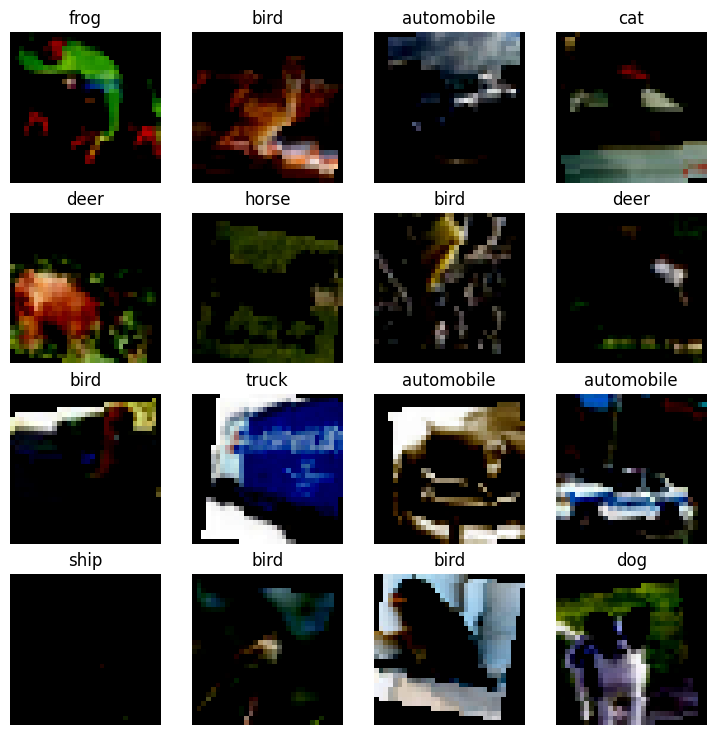

In [26]:
# Plot some more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() # get a random sample from train_data
    image, label = train_data[random_idx]

    # Disaply each sample
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)


# Prepare dataloader

- Create batches of samples from train_data and test_data


In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into batches
train_dataloader = DataLoader(
    train_data, # dataset to turn into batches
    batch_size=BATCH_SIZE, # number of samples per batch
    shuffle=True # shuffle data per epoch -> improved generalisation
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Display batch sizes
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 1563 batches of 32
Test dataloader: 313 batches of 32


# Model 0: Simple CNN

In [28]:
import torch.nn.functional as F
from helper_functions import flatten

class SimpleCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Convolutional layers
        self.Conv1 = nn.Conv2d(in_channels=input_shape, # lowest level features (e.g. edges)
                               out_channels=hidden_units,
                               kernel_size=3,
                               padding=1)

        self.Conv2 = nn.Conv2d(in_channels=hidden_units, # higher level features (e.g. shapes)
                               out_channels=hidden_units*2,
                               kernel_size=3,
                               padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, # reduce spatial size
                                 stride=2)

        # Dynamically calculate flattened size for fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_shape, 32, 32) # batch size of 1
            x = self.pool(F.relu(self.Conv1(dummy_input)))
            x = self.pool(F.relu(self.Conv2(x)))
            flattened_size, _ = flatten(x)

        # Fully connected layers (Classifier)
        self.linear1 = nn.Linear(flattened_size, hidden_units*4) # 8*8 from 32x32 input image after 2x pooling
        self.linear2 = nn.Linear(hidden_units*4, len(class_names))

    def forward(self, x):
        x = self.pool(F.relu(self.Conv1(x)))
        x = self.pool(F.relu(self.Conv2(x)))
        _, x = flatten(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
        
model_0 = SimpleCNN(input_shape=3,
                    hidden_units=32,
                    output_shape=len(class_names))
model_0

SimpleCNN(
  (Conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

# Model 1: Complex CNN


In [29]:
class ComplexCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Convolutional layers with batch normalisation and max pooling
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units), # normalise activations of a layer at each batch -> improved training speed and stability
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),

            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            )
            
        # Dynamically calcualte flattened size for fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_shape, 32, 32) # batch size of 1
            x = self.conv_layers(dummy_input)
            flattened_size, _ = flatten(x)

        # Fully connected layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, hidden_units*4),
            nn.ReLU(),
            nn.Dropout(p=0.5), # randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution -> prevent overfitting
            nn.Linear(hidden_units*4, output_shape)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        _, x = flatten(x)
        x = self.classifier(x)
        return x

model_1 = ComplexCNN(input_shape=3,
                    hidden_units=32,
                    output_shape=len(class_names))
model_1


ComplexCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linea

# Model 2: Pretrained / Loaded CNN

In [30]:
import torch
from torchvision import models

# Load pretrained ResNet18
resnet = models.resnet18(weights="IMAGENET1K_V1")

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final layer for CIFAR-10 (10 classes)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

# Now only the final fc layer will train
print([name for name, param in resnet.named_parameters() if param.requires_grad])


['fc.weight', 'fc.bias']


# Train the models

### Setup evaluation metric

In [31]:
import torchmetrics
from torchmetrics import Accuracy

# Initialise accuracy metric
metric = Accuracy(task="multiclass", num_classes=len(class_names))

### Functionise train and test loops

In [32]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               metric: torchmetrics.Accuracy):
    train_loss = 0

    for batch, (X, y) in enumerate(data_loader):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and update accuracy metric
        loss = loss_fn(y_pred, y)
        train_loss += loss

        metric.update(y_pred, y)

        # 3. Optimiser zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc = metric.compute().item() * 100 # to percentage
    metric.reset() # reset for next epoch
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              metric: torchmetrics.Accuracy):
    test_loss = 0

    # Turn on evaluation
    model.eval()

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and update accuracy metric
            loss = loss_fn(test_pred, y)
            test_loss += loss

            metric.update(test_pred, y)

    # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc = metric.compute().item() * 100 # to percentage
        metric.reset()
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Setup loss function and optimizer for model 0

### Train Model 0

In [33]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [34]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    train_loop(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               metric=metric)

    test_loop(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              metric=metric)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 1.67350 | Train acc: 38.91%


 10%|█         | 1/10 [00:49<07:28, 49.82s/it]

Test loss: 1.34931 | Test accuracy: 51.01%

Epoch: 2
-------
Train loss: 1.31360 | Train acc: 52.49%


 20%|██        | 2/10 [01:43<06:58, 52.27s/it]

Test loss: 1.11002 | Test accuracy: 60.47%

Epoch: 3
-------
Train loss: 1.15749 | Train acc: 58.71%


 30%|███       | 3/10 [02:37<06:11, 53.00s/it]

Test loss: 1.00411 | Test accuracy: 65.01%

Epoch: 4
-------
Train loss: 1.07173 | Train acc: 62.22%


 40%|████      | 4/10 [03:31<05:19, 53.22s/it]

Test loss: 1.01421 | Test accuracy: 65.20%

Epoch: 5
-------
Train loss: 1.00788 | Train acc: 64.57%


 50%|█████     | 5/10 [04:25<04:27, 53.53s/it]

Test loss: 0.89572 | Test accuracy: 69.25%

Epoch: 6
-------
Train loss: 0.96924 | Train acc: 65.98%


 60%|██████    | 6/10 [05:18<03:33, 53.44s/it]

Test loss: 0.95272 | Test accuracy: 68.50%

Epoch: 7
-------
Train loss: 0.92957 | Train acc: 67.21%


 70%|███████   | 7/10 [06:09<02:37, 52.49s/it]

Test loss: 0.88503 | Test accuracy: 69.46%

Epoch: 8
-------
Train loss: 0.90190 | Train acc: 68.41%


 80%|████████  | 8/10 [07:01<01:44, 52.45s/it]

Test loss: 0.91496 | Test accuracy: 69.61%

Epoch: 9
-------
Train loss: 0.88799 | Train acc: 69.03%


 90%|█████████ | 9/10 [07:54<00:52, 52.72s/it]

Test loss: 0.79251 | Test accuracy: 72.80%

Epoch: 10
-------
Train loss: 0.86517 | Train acc: 69.94%


100%|██████████| 10/10 [08:48<00:00, 52.85s/it]

Test loss: 0.80711 | Test accuracy: 72.06%



In [35]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Train Model 1

In [36]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    train_loop(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               metric=metric)
               
    test_loop(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              metric=metric)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 1.93440 | Train acc: 27.13%


 10%|█         | 1/10 [01:08<10:13, 68.19s/it]

Test loss: 1.72631 | Test accuracy: 40.29%

Epoch: 2
-------
Train loss: 1.63286 | Train acc: 39.59%


 20%|██        | 2/10 [02:13<08:53, 66.67s/it]

Test loss: 1.37568 | Test accuracy: 49.74%

Epoch: 3
-------
Train loss: 1.26895 | Train acc: 53.92%


 30%|███       | 3/10 [03:19<07:43, 66.25s/it]

Test loss: 1.06359 | Test accuracy: 62.17%

Epoch: 4
-------
Train loss: 1.11534 | Train acc: 59.98%


 40%|████      | 4/10 [04:25<06:35, 65.95s/it]

Test loss: 0.99029 | Test accuracy: 65.30%

Epoch: 5
-------
Train loss: 1.01422 | Train acc: 63.97%


 50%|█████     | 5/10 [05:30<05:29, 65.87s/it]

Test loss: 1.00797 | Test accuracy: 65.06%

Epoch: 6
-------
Train loss: 0.94654 | Train acc: 66.83%


 60%|██████    | 6/10 [06:37<04:24, 66.13s/it]

Test loss: 0.94356 | Test accuracy: 67.11%

Epoch: 7
-------
Train loss: 0.88876 | Train acc: 68.81%


 70%|███████   | 7/10 [07:44<03:19, 66.36s/it]

Test loss: 0.88605 | Test accuracy: 69.30%

Epoch: 8
-------
Train loss: 0.84098 | Train acc: 70.34%


 80%|████████  | 8/10 [08:50<02:12, 66.26s/it]

Test loss: 0.93294 | Test accuracy: 67.88%

Epoch: 9
-------
Train loss: 0.81107 | Train acc: 71.45%


 90%|█████████ | 9/10 [09:56<01:06, 66.32s/it]

Test loss: 0.77652 | Test accuracy: 72.97%

Epoch: 10
-------
Train loss: 0.77547 | Train acc: 72.87%


100%|██████████| 10/10 [11:03<00:00, 66.38s/it]

Test loss: 0.77765 | Test accuracy: 73.46%



### Train Model 2

In [37]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=resnet.fc.parameters(), lr=0.1)

In [38]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    test_loop(model=resnet,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              metric=metric)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------


 10%|█         | 1/10 [00:11<01:45, 11.70s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 2
-------


 20%|██        | 2/10 [00:22<01:31, 11.41s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 3
-------


 30%|███       | 3/10 [00:34<01:19, 11.32s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 4
-------


 40%|████      | 4/10 [00:45<01:07, 11.33s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 5
-------


 50%|█████     | 5/10 [00:56<00:56, 11.29s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 6
-------


 60%|██████    | 6/10 [01:08<00:45, 11.34s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 7
-------


 70%|███████   | 7/10 [01:19<00:33, 11.27s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 8
-------


 80%|████████  | 8/10 [01:30<00:22, 11.15s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 9
-------


 90%|█████████ | 9/10 [01:40<00:11, 11.04s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

Epoch: 10
-------


100%|██████████| 10/10 [01:51<00:00, 11.19s/it]

Test loss: 2.35027 | Test accuracy: 10.19%

